In [1]:
import numpy as np
import pandas as pd

import pickle as pkl

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 2020

N_FOLD = 5

In [3]:
base_path = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'
train = pd.read_csv(base_path+'train_scores.csv', dtype={'Id':str})\
            #.dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv(base_path+'reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv(base_path+'ICN_numbers.csv')
loading = pd.read_csv(base_path+'loading.csv', dtype={'Id':str})
fnc = pd.read_csv(base_path+'fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv(base_path+'sample_submission.csv', dtype={'Id':str})

In [5]:
site_base_path = '/media/hiroki/working/kaggle/trends-neuroimaging/site_label/adversal/'
site_train = pd.read_csv(site_base_path+'/train_prob_site2_icapca.csv', dtype={'Id':str})
site_test = pd.read_csv(site_base_path+'/test_prob_site2_icapca.csv', dtype={'Id':str})
site_train.drop(["is_site2", "is_site2_true"], axis=1, inplace=True)
site_test.drop(["is_site2", "is_site2_true"], axis=1, inplace=True)

In [6]:
fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

In [7]:
sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [8]:
# merge
train = train.merge(loading, on=ID, how='left')
train = train.merge(fnc, on=ID, how='left')
train = train.merge(site_train, on=ID, how='left')
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4),prob_site2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488,0.234300
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327,0.256662
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358,0.340693
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898,0.334773
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,0.408926,0.072004,0.157582,0.532046,0.355448,0.462675,0.161005,0.703679,0.293607,0.326972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.001115,0.007108,0.008652,0.003596,...,0.205351,0.012067,0.310750,0.426335,0.193812,0.158720,0.055471,0.568766,0.160516,0.249056
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,0.007263,0.016489,0.012704,0.004357,...,0.201846,-0.008290,0.119828,0.551936,0.598931,0.511816,0.303312,0.704483,0.461588,0.262056
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,0.005996,0.003873,0.012353,0.000242,...,0.375065,0.104857,0.262614,0.502715,0.322353,0.458041,0.343754,0.705207,0.341224,0.340606
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.000627,0.011407,0.010957,0.000534,...,0.431489,0.039062,0.119474,0.523894,0.445209,0.332011,0.228977,0.560968,0.263504,0.326198


In [9]:
# merge
test = test.merge(loading, on=ID, how='left')
test = test.merge(fnc, on=ID, how='left')
test = test.merge(site_test, on=ID, how='left')
test

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4),prob_site2
0,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474,0.359684
1,10006,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,...,0.240957,0.270419,0.367692,0.354501,0.486364,0.416908,0.285274,0.693490,0.448526,0.352551
2,10010,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,...,0.272077,0.193523,0.192254,0.563982,0.124482,0.488926,0.083368,0.774299,0.129327,0.349646
3,10011,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,...,0.557121,0.042626,0.179456,0.416546,0.445402,0.436909,0.165182,0.591561,0.306678,0.362414
4,10012,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,...,0.203298,0.173427,0.046047,0.561599,0.418268,0.609517,0.218285,0.790285,0.301010,0.374330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21745,0.005406,0.006275,0.012252,0.003518,0.001400,0.015054,0.015373,0.001532,0.003546,...,0.580813,0.202241,0.254870,0.458581,0.434638,0.587167,0.009854,0.472956,0.342085,0.355726
5873,21748,0.004240,0.009213,0.010981,0.000443,-0.003072,0.010702,0.014673,0.005523,0.005780,...,0.234340,0.138985,0.343382,0.708744,0.312812,0.536501,0.214803,0.849512,0.204741,0.355433
5874,21749,0.004783,0.017910,0.012128,-0.005683,-0.011613,0.017000,0.007230,0.001315,0.008788,...,0.170154,-0.029638,0.383761,0.398305,0.578621,0.357127,0.009479,0.609545,0.317230,0.367950
5875,21751,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,...,0.131902,-0.047932,0.022317,0.583869,0.596734,0.515209,0.379589,0.568422,0.439016,0.352036


In [10]:
# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
FNC_SCALE = 1/600

train[fnc_features] *= FNC_SCALE
test[fnc_features] *= FNC_SCALE

In [11]:
import IPython

def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [12]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [13]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def gpr_predict_cv(train_x, train_y, test_x, model, target_name):
    preds = []
    preds_std = []
    
    preds_test = []
    preds_test_std = []
    
    va_idxes = []
    
    score = []
    mae = []
    rmse = []

    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        print("FOLD:{}".format(i+1))
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        
        # autoscaling
        autoscaled_train_x = (tr_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        autoscaled_train_y = (tr_y - tr_y.mean()) / tr_y.std(ddof=1)
        autoscaled_val_x = (va_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        autoscaled_test_x = (test_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        
        model.fit(autoscaled_train_x, autoscaled_train_y)
        # pred_val
        pred, pred_std = model.predict(autoscaled_val_x, return_std=True)
        pred = pred * tr_y.std(ddof=1) + tr_y.mean()
        preds.append(pred)
        # pred_val_std
        pred_std = pred_std * tr_y.std(ddof=1)
        preds_std.append(pred_std)
        # append valid idx
        va_idxes.append(va_idx)
        # pred_test
        pred_test, pred_test_std = model.predict(autoscaled_test_x, return_std=True)
        pred_test = pred_test * tr_y.std(ddof=1) + tr_y.mean()
        preds_test.append(pred_test)
        # pred_test_std
        pred_test_std = pred_test_std * tr_y.std(ddof=1)
        preds_test_std.append(pred_test_std)
        
        # calc score
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    preds_std = np.concatenate(preds_std, axis=0)
    
    order = np.argsort(va_idxes)
    
    pred_train = preds[order]
    pred_std_train = preds_std[order]

    # テストデータに対する予測値の平均をとる
    pred_test = np.mean(preds_test, axis=0)
    pred_test_std = np.mean(preds_test_std, axis=0)

    return pred_train, pred_std_train, pred_test, pred_test_std, score_cv

# Modeling

In [14]:
import json
f_selec_path = "/media/hiroki/working/kaggle/trends-neuroimaging/feature_selection"

json_path = f_selec_path+"/ridge_No2_columns.json"
with open(json_path) as f:
    f_selec = json.load(f)

In [15]:
f_keys = list(f_selec.keys())

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
#from sklearn.model_selection import train_test_split, GridSearchCV

In [17]:
#ConstantKernel() * RBF(np.ones(x_train.shape[1])) + WhiteKernel(),
#ConstantKernel() * RBF(np.ones(x_train.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),

In [18]:
kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

In [19]:
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4),prob_site2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,0.000921,0.000218,0.000559,0.000658,-0.000071,0.000208,-0.000101,0.000860,0.000484,0.234300
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.000066,0.000238,-0.000317,0.000831,0.000740,0.000987,0.000048,0.001176,0.000414,0.256662
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,0.000516,0.000236,0.000051,0.000574,0.000357,0.000529,0.000021,0.001110,0.000136,0.340693
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,0.000658,0.000067,0.000714,0.000831,0.000445,0.000379,0.000048,0.001254,0.000146,0.334773
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,0.000682,0.000120,0.000263,0.000887,0.000592,0.000771,0.000268,0.001173,0.000489,0.326972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.001115,0.007108,0.008652,0.003596,...,0.000342,0.000020,0.000518,0.000711,0.000323,0.000265,0.000092,0.000948,0.000268,0.249056
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,0.007263,0.016489,0.012704,0.004357,...,0.000336,-0.000014,0.000200,0.000920,0.000998,0.000853,0.000506,0.001174,0.000769,0.262056
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,0.005996,0.003873,0.012353,0.000242,...,0.000625,0.000175,0.000438,0.000838,0.000537,0.000763,0.000573,0.001175,0.000569,0.340606
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.000627,0.011407,0.010957,0.000534,...,0.000719,0.000065,0.000199,0.000873,0.000742,0.000553,0.000382,0.000935,0.000439,0.326198


In [22]:
feature

['IC_01',
 'IC_07',
 'IC_05',
 'IC_16',
 'IC_26',
 'IC_06',
 'IC_10',
 'IC_09',
 'IC_18',
 'IC_04',
 'IC_12',
 'IC_24',
 'IC_15',
 'IC_13',
 'IC_17',
 'IC_02',
 'IC_08',
 'IC_03',
 'IC_21',
 'IC_28',
 'IC_11',
 'IC_20',
 'IC_30',
 'IC_22',
 'IC_29',
 'IC_14',
 'SCN(53)_vs_SCN(69)',
 'SCN(98)_vs_SCN(69)',
 'SCN(99)_vs_SCN(69)',
 'SCN(45)_vs_SCN(69)',
 'ADN(21)_vs_SCN(69)',
 'ADN(56)_vs_SCN(69)',
 'SMN(3)_vs_SCN(69)',
 'SMN(9)_vs_SCN(69)',
 'SMN(2)_vs_SCN(69)',
 'SMN(11)_vs_SCN(69)',
 'SMN(27)_vs_SCN(69)',
 'SMN(54)_vs_SCN(69)',
 'SMN(66)_vs_SCN(69)',
 'SMN(80)_vs_SCN(69)',
 'SMN(72)_vs_SCN(69)',
 'VSN(16)_vs_SCN(69)',
 'VSN(5)_vs_SCN(69)',
 'VSN(62)_vs_SCN(69)',
 'VSN(15)_vs_SCN(69)',
 'VSN(12)_vs_SCN(69)',
 'VSN(93)_vs_SCN(69)',
 'VSN(20)_vs_SCN(69)',
 'VSN(8)_vs_SCN(69)',
 'VSN(77)_vs_SCN(69)',
 'CON(68)_vs_SCN(69)',
 'CON(33)_vs_SCN(69)',
 'CON(43)_vs_SCN(69)',
 'CON(70)_vs_SCN(69)',
 'CON(61)_vs_SCN(69)',
 'CON(55)_vs_SCN(69)',
 'CON(63)_vs_SCN(69)',
 'CON(79)_vs_SCN(69)',
 'CON(84)

In [23]:
#pred_train_targets_gpr = {}
#pred_test_targets_gpr = {}

pred_train_targets_gpr_dfs = {}
pred_train_targets_std_gpr_dfs = {}

pred_test_targets_gpr_dfs = {}
pred_test_targets_std_gpr_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, feature, w in [("age", f_selec[f_keys[0]], 0.3),
                           ("domain1_var1", f_selec[f_keys[1]], 0.175),
                           ("domain1_var2", f_selec[f_keys[2]], 0.175),
                           ("domain2_var1", f_selec[f_keys[3]], 0.175),
                           ("domain2_var2", f_selec[f_keys[4]], 0.175)]:
    
    train_df = train[train[target].notnull()]
    test_df = test
    
    use_idx = train_df.index
    train_x = train_df.drop([ID]+TARGET_COLS, axis=1)
    feature.append('prob_site2')
    train_x = train_x[feature]
    train_y = train_df[target]
    test_x = test_df.drop(ID, axis=1)
    test_x = test_x[feature]
    
    model = GaussianProcessRegressor(kernels[0], random_state=2020)
    
    print("-----{}-----".format(target))
    pred_train, pred_std_train, pred_test, pred_std_test, score_cv = gpr_predict_cv(train_x=train_x,
                                                                                    train_y=train_y,
                                                                                    test_x=test_x,
                                                                                    model=model,
                                                                                    target_name=target)
    overal_score += w*score_cv
    # make pred_train_df
    pred_train_targets_gpr_dfs[target] = pd.Series(pred_train, name="pre_gpr_{}".format(target), index=use_idx)
    pred_train_targets_gpr_dfs[target] = pd.merge(train['Id'],
                                                 pred_train_targets_gpr_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    # make pred_train_std_df
    pred_train_targets_std_gpr_dfs[target] = pd.Series(pred_std_train, name="pre_gpr_std_{}".format(target), index=use_idx)
    pred_train_targets_std_gpr_dfs[target] = pd.merge(train['Id'],
                                                      pred_train_targets_std_gpr_dfs[target],
                                                      left_index=True,
                                                      right_index=True)
    # make pred_test_df
    pred_test_targets_gpr_dfs[target] = pd.Series(pred_test, name="pre_gpr_{}".format(target))
    pred_test_targets_gpr_dfs[target] = pd.concat([test['Id'], pred_test_targets_gpr_dfs[target]], axis=1)
    # make pred_test_std_df
    pred_test_targets_std_gpr_dfs[target] = pd.Series(pred_std_test, name="pre_gpr_std_{}".format(target))
    pred_test_targets_std_gpr_dfs[target] = pd.concat([test['Id'], pred_test_targets_std_gpr_dfs[target]], axis=1)
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:5
-----age-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
age_score:0.14505123
age_mae:7.2568410292369805
age_rmse:9.220112397822493
-----domain1_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5


KeyboardInterrupt: 

In [19]:
for i, pred_df in enumerate(pred_train_targets_gpr_dfs.values()):
    if i == 0:
        pred_train_dfs = pred_df
    else:
        pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [20]:
for i, pred_df in enumerate(pred_train_targets_std_gpr_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [21]:
for i, pred_df in enumerate(pred_test_targets_gpr_dfs.values()):
    if i == 0:
        pred_test_dfs = pred_df
        #display(pred_train_dfs, head=False)
    else:
        pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_train_dfs, head=False)

In [22]:
for i, pred_df in enumerate(pred_test_targets_std_gpr_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [25]:
pred_train_dfs.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_FeatureSelection/gpr_train.csv', index=False)
pred_test_dfs.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_FeatureSelection/gpr_test.csv', index=False)

In [27]:
pred_train_dfs.describe()

,pre_gpr_age,pre_gpr_domain1_var1,pre_gpr_domain1_var2,pre_gpr_domain2_var1,pre_gpr_domain2_var2,pre_gpr_std_age,pre_gpr_std_domain1_var1,pre_gpr_std_domain1_var2,pre_gpr_std_domain2_var1,pre_gpr_std_domain2_var2
count,5877.000000,5439.000000,5439.000000,5838.000000,5838.000000,5877.000000,5439.000000,5439.000000,5838.000000,5838.000000
mean,50.051884,51.494082,59.245774,47.316803,51.909438,9.193239,9.750634,11.367836,10.923679,11.688994
std,9.967027,2.946490,0.658263,2.107089,1.874764,0.249035,0.110762,0.046033,0.110642,0.095233
min,20.504395,40.775900,55.971928,39.611331,45.392993,8.771745,9.517539,11.301150,10.687694,11.488611
25%,42.793750,49.513985,58.826667,45.874435,50.657894,9.069708,9.702350,11.329224,10.833360,11.641378
50%,49.971546,51.483149,59.251912,47.301466,51.846915,9.162989,9.753275,11.345916,10.939939,11.680612
75%,56.831137,53.456695,59.692514,48.723477,53.119300,9.276738,9.801920,11.411933,10.999940,11.738994
max,81.245820,61.530057,61.617543,54.721385,59.334520,19.434977,13.654299,12.345635,13.752474,13.806723


In [28]:
pred_test_dfs.describe()

,pre_gpr_age,pre_gpr_domain1_var1,pre_gpr_domain1_var2,pre_gpr_domain2_var1,pre_gpr_domain2_var2,pre_gpr_std_age,pre_gpr_std_domain1_var1,pre_gpr_std_domain1_var2,pre_gpr_std_domain2_var1,pre_gpr_std_domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,49.085358,51.353849,59.259484,47.308421,51.857999,9.206768,9.754956,11.368510,10.926607,11.691229
std,10.117436,2.880258,0.611593,2.032852,1.769944,0.282144,0.105062,0.022830,0.078599,0.063543
min,15.863898,41.010010,56.840921,39.530222,45.790250,8.873691,9.622042,11.338667,10.826553,11.608980
25%,41.865562,49.418149,58.856434,45.894891,50.650276,9.086273,9.710360,11.358056,10.893584,11.664077
50%,48.964557,51.385238,59.280832,47.345819,51.799045,9.171020,9.741982,11.365540,10.916701,11.683219
75%,56.139402,53.354075,59.683692,48.681254,53.006607,9.277757,9.782417,11.375073,10.946849,11.708052
max,83.363495,62.419044,61.212316,54.255070,59.368702,22.502921,14.736992,12.354614,14.613333,14.627065


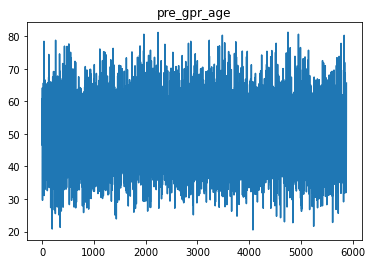

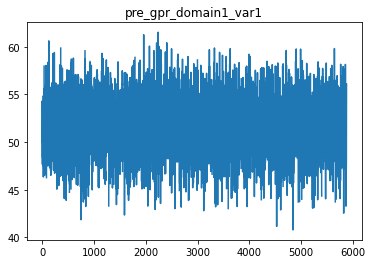

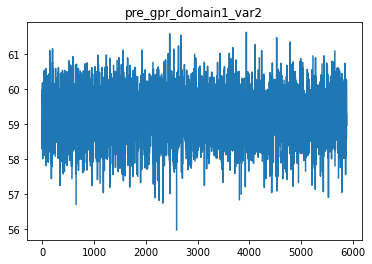

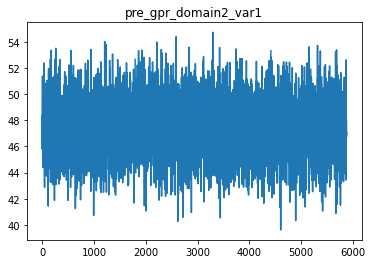

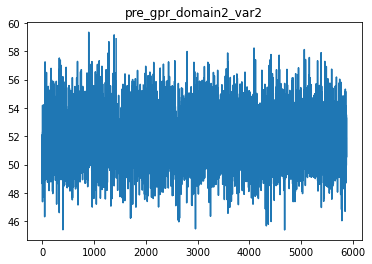

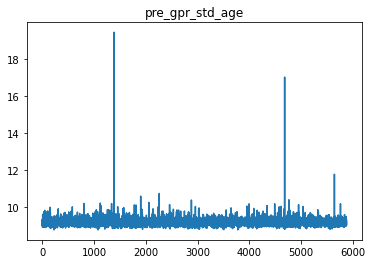

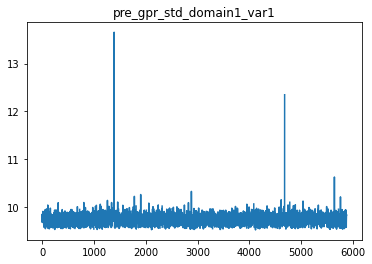

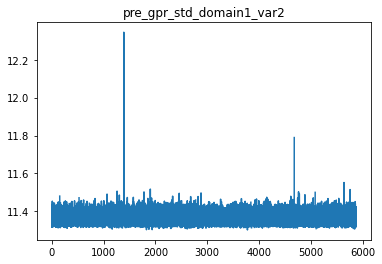

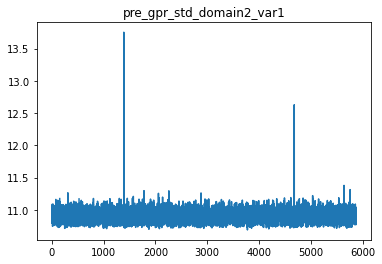

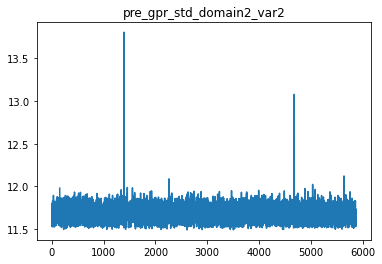

In [29]:
for col in pred_train_dfs.drop('Id', axis=1).columns:
    plt.plot(pred_train_dfs[col])
    plt.title(col)
    plt.show()

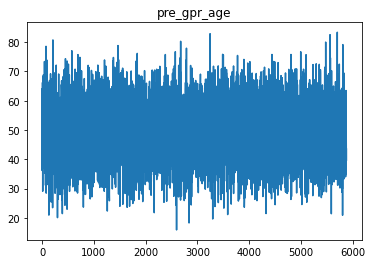

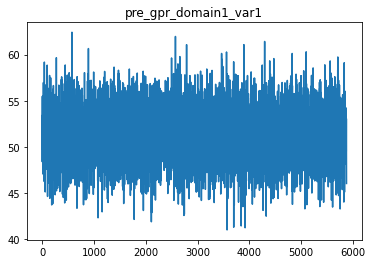

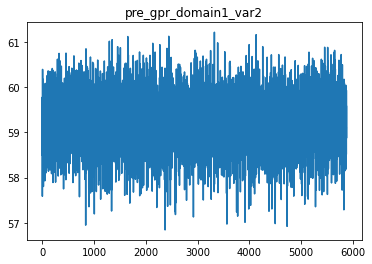

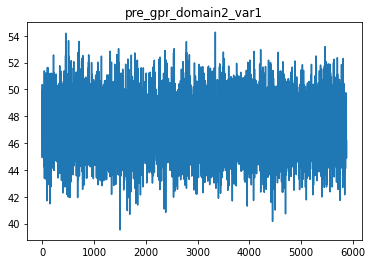

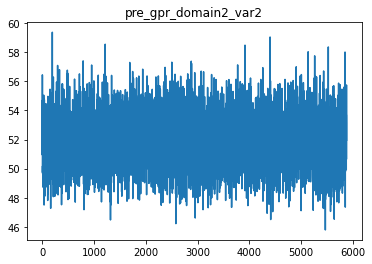

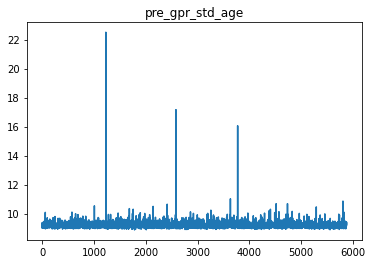

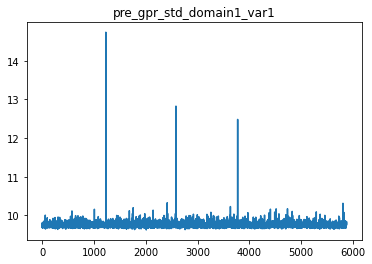

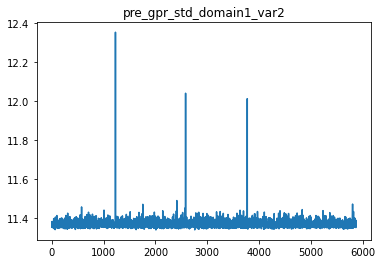

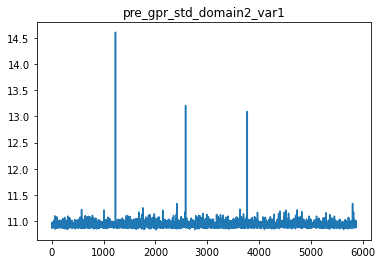

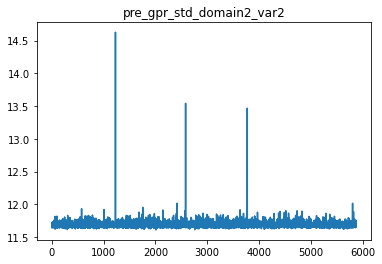

In [24]:
for col in pred_test_dfs.drop('Id', axis=1).columns:
    plt.plot(pred_test_dfs[col])
    plt.title(col)
    plt.show()